In [55]:
import pandas as pd
import datetime
import sys, os
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
from coinmetrics.api_client import CoinMetricsClient
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions
import tensorflow as tf
import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
SYMBOL      = cfg['SYMBOL']
STABLECOIN  = cfg['STABLECOIN']
PAIR        = SYMBOL + STABLECOIN #binance
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']

map_ohlc = {'Open':'Open','High':'High','Low':'Low','Close':'Close'}

In [2]:
import yfinance as yf

ticker = "BTC-USD"
interval = "1h"

# Define the start and end dates
end_date = "2023-07-19"
start_date = (pd.to_datetime(end_date) - pd.Timedelta(hours=700)).strftime("%Y-%m-%d")

# Download the first chunk of historical data
data = yf.download(ticker, start=start_date, end=end_date, interval=interval)

# Download additional chunks of historical data if needed
while start_date > "2009-01-01":
    end_date = start_date
    start_date = (pd.to_datetime(start_date) - pd.Timedelta(hours=700)).strftime("%Y-%m-%d")
    chunk = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    data = pd.concat([chunk, data])

# Print the data
data = data.reset_index()
data.columns = ['Time','Open','High','Low','Close','Adj_Close','Volume']
data.to_csv(DATA_PATH / f'{ticker}_{interval}.csv',index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [71]:
df = data.copy()
df.drop(columns='Adj_Close',inplace=True)

In [72]:
MAX_LENGTH  = 20
df = labelize_output_according_criterion2(df, map_ohlc, max_trade_length=MAX_LENGTH)
df = df.drop(columns=['TP','SL'])

In [73]:
df

,Time,Open,High,Low,Close,Volume,signal
0,2021-08-28 00:00:00,49044.132812,49264.675781,48902.218750,49238.804688,0.0,0
1,2021-08-28 01:00:00,49247.457031,49283.503906,49092.316406,49130.039062,9052160.0,0
2,2021-08-28 02:00:00,49132.082031,49132.082031,48878.121094,48972.496094,173776896.0,0
3,2021-08-28 03:00:00,48981.972656,49049.718750,48896.222656,48911.859375,0.0,0
4,2021-08-28 04:00:00,48969.011719,49099.828125,48969.011719,49030.125000,0.0,0
...,...,...,...,...,...,...,...
16394,2023-07-18 19:00:00,29909.402344,29936.634766,29710.734375,29720.015625,0.0,0
16395,2023-07-18 20:00:00,29719.406250,29794.064453,29704.521484,29777.044922,0.0,0
16396,2023-07-18 21:00:00,29776.722656,29833.054688,29764.291016,29800.257812,0.0,0
16397,2023-07-18 22:00:00,29797.849609,29823.927734,29770.392578,29821.093750,0.0,0


In [75]:
#TENTATIVO DI NORMALIZZAZIONE DEI DATI
df['Delta_Open_PrevClose'] = df['Open']- df['Close'].shift()
df['High'] = df['High']  - df['Close'].shift()
df['Low'] = df['Low'] -  df['Close'].shift()
df['Close'] = df['Close'] - df['Close'].shift()
df['Open'] = = df['Open']- df['Close'].shift()
df = df.drop(columns='Delta_Open_PrevClose')
df = df.dropna().reset_index(drop=True)
df

,Time,Open,High,Low,Close,Volume,signal
0,2021-08-28 02:00:00,110.808594,110.808594,-143.152344,-48.777344,173776896.0,0
1,2021-08-28 03:00:00,167.019531,234.765625,81.269531,96.906250,0.0,0
2,2021-08-28 04:00:00,117.789062,248.605469,117.789062,178.902344,0.0,0
3,2021-08-28 05:00:00,-160.472656,-94.117188,-210.843750,-189.828125,0.0,0
4,2021-08-28 06:00:00,-5.007812,186.777344,-200.738281,148.378906,0.0,0
...,...,...,...,...,...,...,...
16392,2023-07-18 19:00:00,-94.552734,-67.320312,-293.220703,-283.939453,0.0,0
16393,2023-07-18 20:00:00,181.341797,256.000000,166.457031,238.980469,0.0,0
16394,2023-07-18 21:00:00,-57.351562,-1.019531,-69.783203,-33.816406,0.0,0
16395,2023-07-18 22:00:00,-25.621094,0.457031,-53.078125,-2.376953,0.0,0


In [96]:
print(pd.cut(df['Open'], [.1, .2, .3, .4, .5, .6, .7, .8, .9]))
        #      [.001,.01,.1,.25,.5,.75,.95,.99]))
quantiles = df['Open'].quantile([.001,.01,.05,.1,.25,.5,.75,.9,.95,.99,.999])
print(quantiles)
print(quantiles.iloc[0])
df['ad2']=pd.qcut(df['Open'], [.1, .2, .3, .4, .5, .6, .7, .8, .9], labels=False)
df.head(5)

201      NaN
202      NaN
203      NaN
204      NaN
205      NaN
        ... 
16391    NaN
16392    NaN
16393    NaN
16394    NaN
16395    NaN
Name: Open, Length: 16195, dtype: category
Categories (8, interval[float64, right]): [(0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] < (0.4, 0.5] < (0.5, 0.6] < (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9]]
0.001   -1550.043734
0.010    -667.401719
0.050    -304.318945
0.100    -183.500000
0.250     -66.420898
0.500      -0.140625
0.750      65.294922
0.900     193.260938
0.950     316.779785
0.990     680.499453
0.999    1350.962719
Name: Open, dtype: float64
-1550.043734375


,Time,Open,High,Low,Close,Open_pct,High_pct,Low_pct,Close_pct,cons_green_candles,...,STD_Close_99d,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,signal,ad2
201,2021-09-05 19:00:00,-125.460938,330.175781,-141.585938,192.558594,-295.639,79.474,-1009.561,12.870,1,...,319.183671,101878.216011,71.020745,144.990234,-4.649976,298.086011,88855.269673,68.571851,0,0.0
202,2021-09-05 20:00:00,-298.753906,655.589844,-334.082031,655.589844,138.125,98.558,135.957,240.463,2,...,331.647236,109989.889202,188.483507,165.771484,-8.517471,305.096875,93084.103251,178.103408,0,NaN
203,2021-09-05 21:00:00,-948.781250,-808.273438,-1100.343750,-891.859375,217.580,-223.289,229.363,-236.039,3,...,331.146419,109657.950846,-916.960415,-163.815430,-8.573828,305.090329,93080.108678,-928.740625,0,NaN
204,2021-09-05 22:00:00,-33.011719,125.207031,-133.078125,125.207031,-96.521,-115.491,-87.906,-114.039,4,...,330.587074,109287.813547,47.385663,32.352539,-9.303066,305.582953,93380.940983,30.384121,0,2.0
205,2021-09-05 23:00:00,-224.535156,-192.218750,-437.347656,-294.281250,580.168,-253.521,228.640,-335.036,0,...,326.104665,106344.252347,-267.704595,-141.248047,-9.293472,305.586644,93383.196940,-277.802231,0,NaN


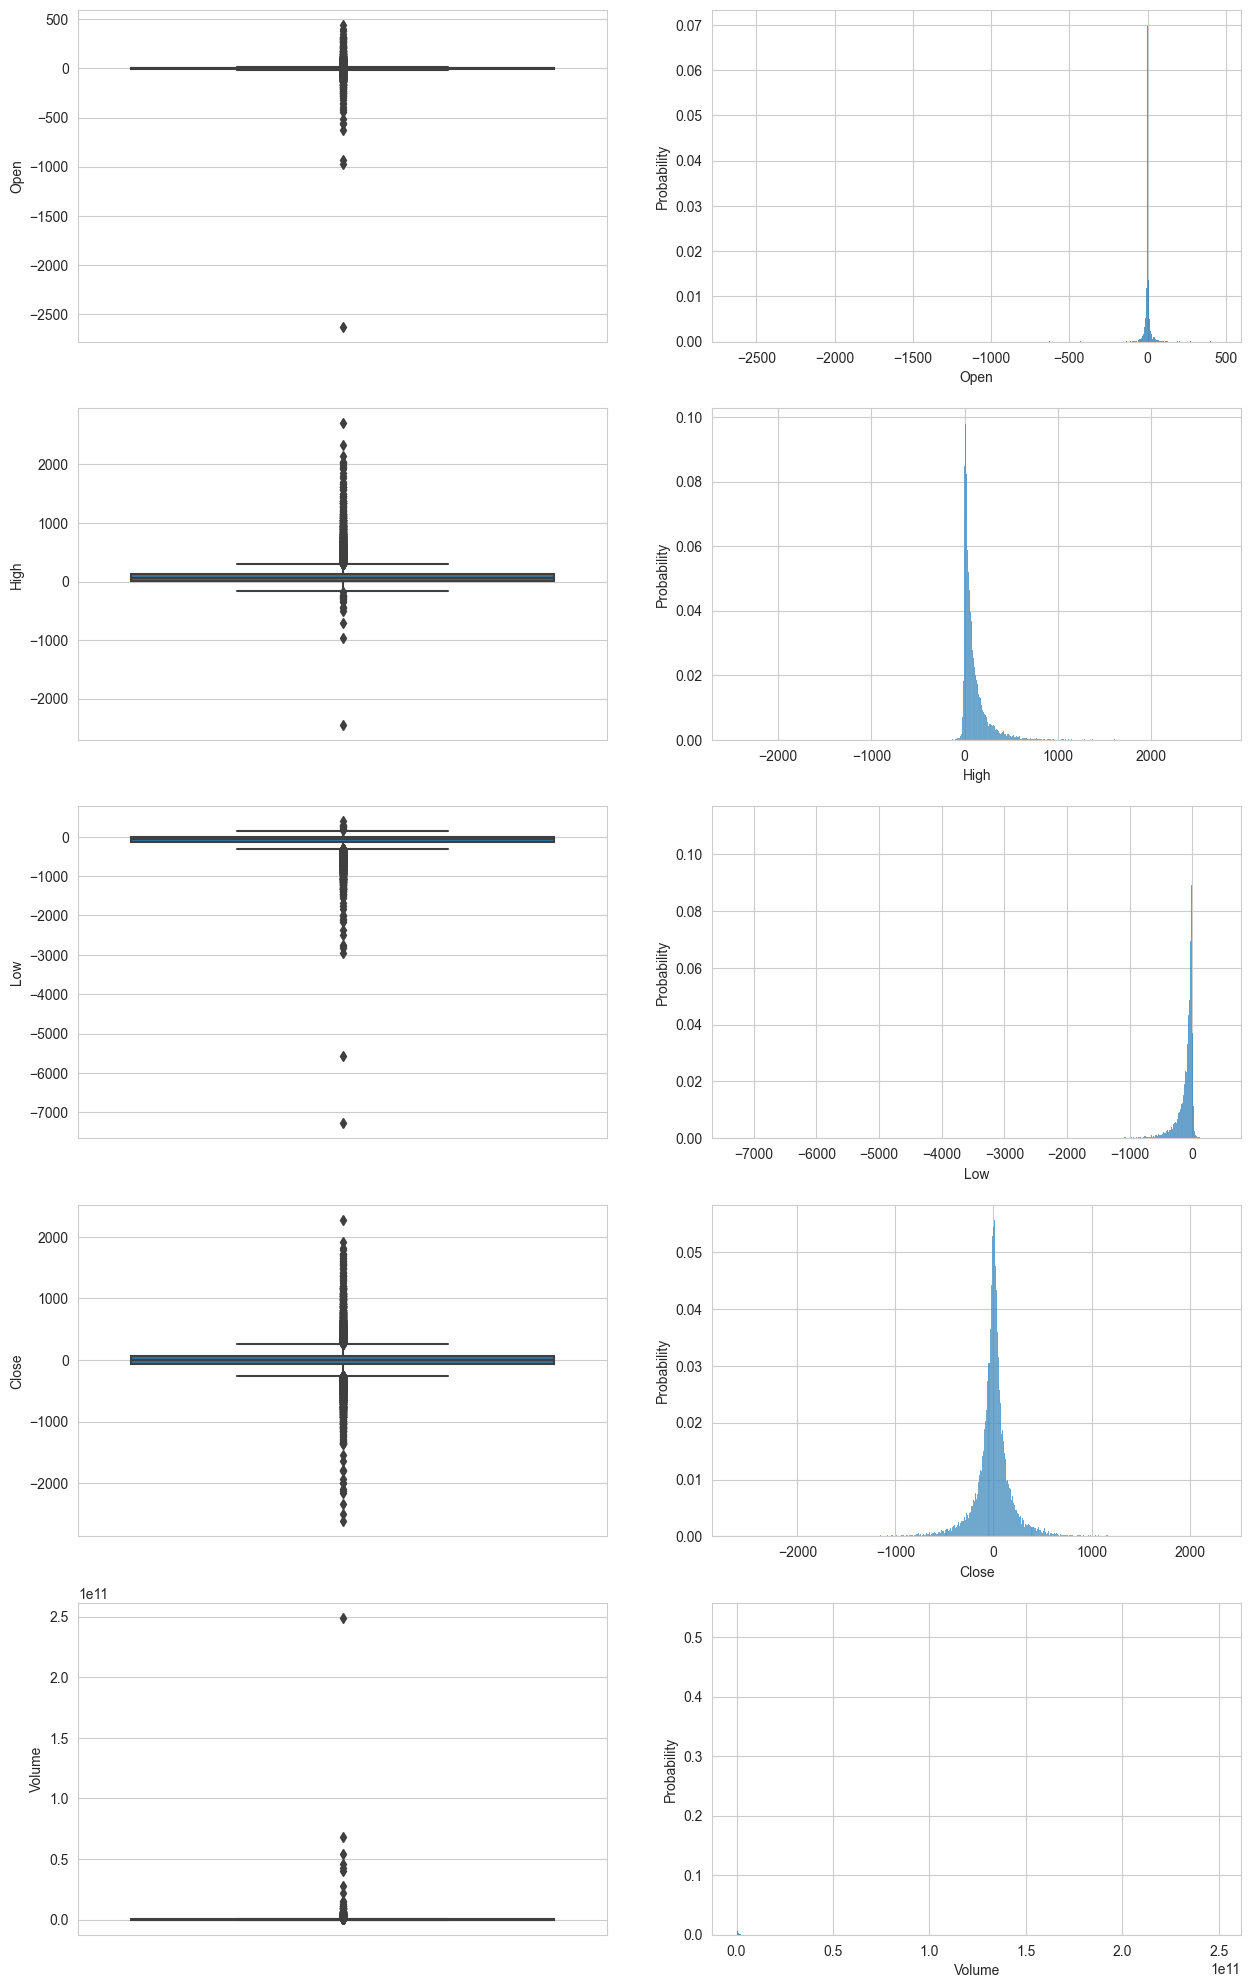

In [21]:
target_columns = [col for col in df.columns if col not in ['Time']]
fig, axs = plt.subplots(figsize=(15,5*len(target_columns)), nrows=len(target_columns), ncols=2)

for i,col in enumerate([col for col in target_columns]):
    sns.set_style('whitegrid')
    sns.boxplot(y=col,data=df, ax=axs[i][0])
    sns.histplot(data=df, x=col, stat='probability', ax=axs[i][1])
    #stat = ['count', 'frequency', 'density', 'probability', 'proportion', 'percent']
    

plt.show()

In [76]:
map_ohlc = {'Open':'Open','High':'High','Low':'Low','Close':'Close'}
lags_relevant = [13,30,99,200]
#lags_relevant = [10]

In [77]:
def transform_percentages(df, columns, suffix='_pct'):

    df_perc = df.copy()

    for col in columns:
        df_perc[col+suffix] = np.round(100 * (df_perc[col]-df_perc[col].shift()) / df_perc[col].shift(),3)

    return df_perc

df = transform_percentages(df,map_ohlc)

In [82]:
df

,Time,Open,High,Low,Close,Volume,signal,Open_pct,High_pct,Low_pct,...,Close_lag_99d,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d
1,2021-08-28 03:00:00,167.019531,234.765625,81.269531,96.906250,0.0,0,50.728,111.866,-156.771,...,NaN,76.206055,97.275520,9462.526751,68.784180,NaN,76.206055,97.275520,9462.526751,68.784180
2,2021-08-28 04:00:00,117.789062,248.605469,117.789062,178.902344,0.0,0,-29.476,5.895,44.936,...,NaN,106.061198,86.053775,7405.252107,59.710286,NaN,106.061198,86.053775,7405.252107,59.710286
3,2021-08-28 05:00:00,-160.472656,-94.117188,-210.843750,-189.828125,0.0,0,-236.237,-137.858,-279.001,...,NaN,38.592041,152.135411,23145.183270,-202.407471,NaN,38.592041,152.135411,23145.183270,-202.407471
4,2021-08-28 06:00:00,-5.007812,186.777344,-200.738281,148.378906,0.0,0,-96.879,-298.452,-4.793,...,NaN,37.344141,131.782676,17366.673729,-4.991602,NaN,37.344141,131.782676,17366.673729,-4.991602
5,2021-08-28 07:00:00,-83.839844,-83.839844,-246.234375,-151.078125,126953472.0,0,1574.181,-144.888,22.664,...,NaN,7.578776,138.597260,19209.200556,-148.826823,NaN,7.578776,138.597260,19209.200556,-148.826823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16392,2023-07-18 19:00:00,-94.552734,-67.320312,-293.220703,-283.939453,0.0,0,47.748,-290.694,228.424,...,48.034180,5.051274,103.835303,10781.770092,-189.809575,-20.599609,0.534243,124.332695,15458.619157,-185.292544
16393,2023-07-18 20:00:00,181.341797,256.000000,166.457031,238.980469,0.0,0,-291.789,-480.272,-156.769,...,-216.508789,9.366462,103.409746,10693.575642,201.328362,-66.785645,1.921646,125.123371,15655.857979,208.773179
16394,2023-07-18 21:00:00,-57.351562,-1.019531,-69.783203,-33.816406,0.0,0,-131.626,-100.398,-141.923,...,140.206055,7.541223,102.668852,10540.893155,-48.033899,133.895020,1.049707,124.806296,15576.611485,-41.542383
16395,2023-07-18 22:00:00,-25.621094,0.457031,-53.078125,-2.376953,0.0,0,-55.326,-144.828,-23.939,...,633.046875,0.943226,80.698953,6512.320967,-21.098011,-17.634277,1.037104,124.808319,15577.116548,-21.191890


In [78]:
df['green_candle']=np.where(df[map_ohlc['Open']]<df[map_ohlc['Close']],1,0)
#conto le candele consecutive verdi
df['cons_green_candles'] = df['green_candle'].groupby((df['green_candle'] == 0).cumsum()).cumsum() - 1 
#setto a 0 se ci sono -1
df['cons_green_candles'] = df['cons_green_candles'].clip(lower=0)
#conto le ultime n = 24 candele ad 1
df['rolling_count'] = df['green_candle'].rolling(window=24, min_periods=1).sum() -1 
df['rolling_count'] = df['rolling_count'].clip(lower=0)

df = df.drop(columns=['green_candle'])

In [83]:
print(df.columns)
df['AVG_Candle_Price'] = (df[map_ohlc['Open']]+df[map_ohlc['High']]+df[map_ohlc['Low']]+df[map_ohlc['Close']])/4
for lag in lags_relevant:
    df['Close_lag_'+str(lag)+'d'] = df['AVG_Candle_Price'].shift(lag)
    df['SMA_Close_'+str(lag)+'d'] = my_functions.rolling_kpi(df,'AVG_Candle_Price',lag,'mean', False)
    df['STD_Close_'+str(lag)+'d'] = my_functions.rolling_kpi(df,'AVG_Candle_Price',lag,'std', False)
    df['VAR_Close_lag_'+str(lag)+'d'] = df['STD_Close_'+str(lag)+'d']**2
    df['diff_Close_'+str(lag)+'d'] = df['AVG_Candle_Price'] - df['SMA_Close_'+str(lag)+'d']


Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'signal', 'Open_pct',
       'High_pct', 'Low_pct', 'Close_pct', 'cons_green_candles',
       'rolling_count', 'AVG_Candle_Price', 'Close_lag_13d', 'SMA_Close_13d',
       'STD_Close_13d', 'VAR_Close_lag_13d', 'diff_Close_13d', 'Close_lag_30d',
       'SMA_Close_30d', 'STD_Close_30d', 'VAR_Close_lag_30d', 'diff_Close_30d',
       'Close_lag_99d', 'SMA_Close_99d', 'STD_Close_99d', 'VAR_Close_lag_99d',
       'diff_Close_99d', 'Close_lag_200d', 'SMA_Close_200d', 'STD_Close_200d',
       'VAR_Close_lag_200d', 'diff_Close_200d'],
      dtype='object')


In [84]:
df.tail(10)

,Time,Open,High,Low,Close,Volume,signal,Open_pct,High_pct,Low_pct,...,Close_lag_99d,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d
16387,2023-07-18 14:00:00,44.015625,221.099609,44.015625,134.695312,415912960.0,0,-52.443,32.438,-13.794,...,54.772461,5.702997,100.588509,10118.048105,105.253546,33.316406,0.673628,122.506248,15007.780816,110.282915
16388,2023-07-18 15:00:00,-127.000000,-127.000000,-207.759766,-141.994141,0.0,0,-388.534,-157.440,-572.014,...,-89.761230,3.356095,100.720749,10144.669250,-154.294572,43.908691,0.371570,122.723066,15060.951018,-151.310046
16389,2023-07-18 16:00:00,3.796875,55.943359,-344.107422,-184.658203,379166720.0,0,-102.990,-144.050,65.628,...,115.086914,6.631698,102.648768,10536.769587,-123.888045,-56.844727,1.208743,123.691932,15299.693969,-118.465090
16390,2023-07-18 17:00:00,189.335938,277.458984,161.279297,277.458984,0.0,0,4886.626,395.964,-146.869,...,-97.901367,7.402714,102.114678,10427.407418,218.980587,58.948730,1.355037,123.643266,15287.657210,225.028264
16391,2023-07-18 18:00:00,-63.996094,35.302734,-89.281250,17.886719,0.0,0,-133.800,-87.276,-155.358,...,-101.352539,5.051274,103.835303,10781.770092,-30.073247,-54.280762,0.534243,124.332695,15458.619157,-25.556216
16392,2023-07-18 19:00:00,-94.552734,-67.320312,-293.220703,-283.939453,0.0,0,47.748,-290.694,228.424,...,48.034180,9.366462,103.409746,10693.575642,-194.124763,-20.599609,1.921646,125.123371,15655.857979,-186.679946
16393,2023-07-18 20:00:00,181.341797,256.000000,166.457031,238.980469,0.0,0,-291.789,-480.272,-156.769,...,-216.508789,7.541223,102.668852,10540.893155,203.153601,-66.785645,1.049707,124.806296,15576.611485,209.645117
16394,2023-07-18 21:00:00,-57.351562,-1.019531,-69.783203,-33.816406,0.0,0,-131.626,-100.398,-141.923,...,140.206055,0.943226,80.698953,6512.320967,-41.435902,133.895020,1.037104,124.808319,15577.116548,-41.529780
16395,2023-07-18 22:00:00,-25.621094,0.457031,-53.078125,-2.376953,0.0,0,-55.326,-144.828,-23.939,...,633.046875,0.528547,80.641079,6502.983681,-20.683332,-17.634277,1.544507,124.560153,15515.231783,-21.699292
16396,2023-07-18 23:00:00,-19.033203,15.285156,-46.121094,15.285156,0.0,0,-25.713,3244.444,-13.107,...,32.407227,NaN,NaN,NaN,NaN,-110.126465,NaN,NaN,NaN,NaN


In [53]:
def return_index_if_exists(df_series, curr_idx, val, pos_crit, max_length):
    
    current_val = val

    if pos_crit:  

        try:
            
            thing_index = list(el >= current_val for el in df_series[curr_idx+1:]).index(True) +1
            #print(current_val)
            #print(list(df_series[curr_idx+1:]))
            #print(list(el >= current_val for el in df_series[curr_idx+1:]))
            #print(thing_index)
        except ValueError:
            thing_index = max_length
    else:

        try:
            
            thing_index = list(el <= current_val for el in df_series[curr_idx+1:]).index(True) +1
        except ValueError:
            thing_index = max_length

    return thing_index

def labelize_output_according_criterion2(df: pd.DataFrame, map_ohlc:dict, wrt:str='Close', target_var:str='signal', threshold:float=0.015, risk_reward_ratio:float=.5, max_trade_length:int=5) -> pd.DataFrame:
    
    df_ = df.copy()
    positive_criterion = 1 + threshold/risk_reward_ratio
    negative_criterion = 1 - threshold
    
    min_above = []
    min_below = []

    df_['TP'] = df_[map_ohlc[wrt]]*positive_criterion
    df_['SL'] = df_[map_ohlc[wrt]]*negative_criterion

    for idx,row in df_.iterrows():

        pos_val = positive_criterion*row[map_ohlc[wrt]]
        neg_val = negative_criterion*row[map_ohlc[wrt]]

        if idx != df_.index[-1]:
            candidates_above_minima = []
            candidates_below_minima = []
            for _,v in map_ohlc.items():
                candidates_above_minima.append(return_index_if_exists(df_[v], idx, pos_val, True, max_trade_length))
                candidates_below_minima.append(return_index_if_exists(df_[v], idx, neg_val, False, max_trade_length))

            min_above.append(min(candidates_above_minima))
            min_below.append(min(candidates_below_minima))

    min_above.append(None)
    min_below.append(None)

    df_['min_above'] = min_above
    df_['min_below'] = min_below

    df_[target_var] = (df_['min_above'].lt(df_['min_below'])) & (df_['min_above'] <= max_trade_length)
    df_[target_var]=df_[target_var].astype(int)

    df_ = df_.drop(columns=['min_above','min_below'])

    return df_


In [81]:
df.head()

,Time,Open,High,Low,Close,Volume,Open_pct,High_pct,Low_pct,Close_pct,...,Close_lag_99d,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d
0,2021-07-29 00:00:00,39995.453125,40200.531250,39620.410156,39647.917969,0.0,NaN,NaN,NaN,NaN,...,NaN,39866.078125,0.000000,0.000000,0.000000,NaN,39866.078125,0.000000,0.000000,0.000000
1,2021-07-29 01:00:00,39604.121094,39728.531250,39352.058594,39685.195312,0.0,-0.978,-1.174,-0.677,0.094,...,NaN,39729.277344,193.465520,37428.907501,-136.800781,NaN,39729.277344,193.465520,37428.907501,-136.800781
2,2021-07-29 02:00:00,39684.011719,39942.167969,39655.148438,39764.554688,0.0,0.202,0.538,0.770,0.200,...,NaN,39740.008464,138.057686,19059.924547,21.462240,NaN,39740.008464,138.057686,19059.924547,21.462240
3,2021-07-29 03:00:00,39727.890625,39855.910156,39574.535156,39700.894531,0.0,0.111,-0.216,-0.203,-0.160,...,NaN,39733.708252,113.425689,12865.387029,-18.900635,NaN,39733.708252,113.425689,12865.387029,-18.900635
4,2021-07-29 04:00:00,39640.609375,40110.203125,39579.765625,39983.476562,4128768.0,-0.220,0.638,0.013,0.712,...,NaN,39752.669336,106.989036,11446.653801,75.844336,NaN,39752.669336,106.989036,11446.653801,75.844336


In [83]:
MAX_LENGTH  = 20
df = labelize_output_according_criterion2(df, map_ohlc, max_trade_length=MAX_LENGTH)

,Time,Open,High,Low,Close,Volume,Open_pct,High_pct,Low_pct,Close_pct,...,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,TP,SL,signal
0,2021-07-29 00:00:00,39995.453125,40200.531250,39620.410156,39647.917969,0.0,NaN,NaN,NaN,NaN,...,0.000000,0.000000,NaN,39866.078125,0.000000,0.000000,0.000000,40837.355508,39053.199199,0
1,2021-07-29 01:00:00,39604.121094,39728.531250,39352.058594,39685.195312,0.0,-0.978,-1.174,-0.677,0.094,...,37428.907501,-136.800781,NaN,39729.277344,193.465520,37428.907501,-136.800781,40875.751172,39089.917383,0
2,2021-07-29 02:00:00,39684.011719,39942.167969,39655.148438,39764.554688,0.0,0.202,0.538,0.770,0.200,...,19059.924547,21.462240,NaN,39740.008464,138.057686,19059.924547,21.462240,40957.491328,39168.086367,0
3,2021-07-29 03:00:00,39727.890625,39855.910156,39574.535156,39700.894531,0.0,0.111,-0.216,-0.203,-0.160,...,12865.387029,-18.900635,NaN,39733.708252,113.425689,12865.387029,-18.900635,40891.921367,39105.381113,0
4,2021-07-29 04:00:00,39640.609375,40110.203125,39579.765625,39983.476562,4128768.0,-0.220,0.638,0.013,0.712,...,11446.653801,75.844336,NaN,39752.669336,106.989036,11446.653801,75.844336,41182.980859,39383.724414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17085,2023-07-18 19:00:00,29909.402344,29936.634766,29710.734375,29720.015625,0.0,0.300,0.058,-0.282,-0.608,...,32337.241956,-395.082815,30210.437500,30459.515454,380.401972,144705.660419,-640.318677,30611.616094,29274.215391,0
17086,2023-07-18 20:00:00,29719.406250,29794.064453,29704.521484,29777.044922,0.0,-0.635,-0.476,-0.021,0.192,...,28326.760178,-453.031171,30204.938965,30457.234556,383.292737,146913.321999,-708.475278,30670.356270,29330.389248,0
17087,2023-07-18 21:00:00,29776.722656,29833.054688,29764.291016,29800.257812,0.0,0.193,0.131,0.201,0.078,...,29505.888698,-401.892701,30217.180176,30455.116562,385.788126,148832.477964,-661.535020,30694.265547,29353.253945,0
17088,2023-07-18 22:00:00,29797.849609,29823.927734,29770.392578,29821.093750,0.0,0.071,-0.031,0.020,0.070,...,30998.840751,-389.011403,30268.398926,30452.791147,388.312689,150786.744764,-649.475229,30715.726562,29373.777344,0


In [84]:
#df = my_functions.labelize_output_according_criterion2(df, map_ohlc, max_trade_length=MAX_LENGTH)
#df['signal'] = (df['min_above'].lt(df['min_below'])) & (df['min_above'] <= MAX_LENGTH)
#df['signal']=df['signal'].astype(int)
#df.drop(columns=['CloseAbovethreshold', 'HighAbovethreshold',
#       'LowAbovethreshold', 'OpenAbovethreshold', 'CloseBelowthreshold',
#       'HighBelowthreshold', 'LowBelowthreshold', 'OpenBelowthreshold', 'TP',
#       'SL', 'min_above', 'min_below'], inplace=True, errors='ignore')


features = [col for col in df.columns if col not in ['Time','YM','train_test','signal']]
for feature in features:
     df[feature] = df[feature] - df[feature].shift()
     df[feature] = np.sqrt(np.absolute(df[feature] - df[feature].shift().fillna(0)))*np.sign(df[feature] - df[feature].shift().fillna(0))



df = my_functions.round_float_cols(df)
df.head()

,Time,Open,High,Low,Close,Volume,Open_pct,High_pct,Low_pct,Close_pct,...,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,TP,SL,signal
0,2021-07-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2021-07-29 01:00:00,-19.78,-21.73,-16.38,6.11,0.00,NaN,NaN,NaN,NaN,...,193.47,-11.70,NaN,-11.70,13.91,193.47,-11.70,6.20,6.06,0
2,2021-07-29 02:00:00,21.71,26.18,23.90,6.49,0.00,1.09,1.31,1.20,0.33,...,-236.22,17.18,NaN,12.15,-15.78,-236.22,17.18,6.58,6.44,0
3,2021-07-29 03:00:00,-6.00,-17.32,-19.59,-11.96,0.00,-1.13,-1.57,-1.56,-0.68,...,110.34,-14.09,NaN,-4.13,5.55,110.34,-14.09,-12.14,-11.87,0
4,2021-07-29 04:00:00,-11.45,18.45,9.27,18.61,2031.94,-0.49,1.27,1.09,1.11,...,69.11,11.62,NaN,5.03,4.27,69.11,11.62,18.88,18.47,0


In [18]:
#from sklearn.preprocessing import MinMaxScaler
#
#scaler = MinMaxScaler(feature_range=(-1,1))
#

In [85]:
df.drop(columns=['TP','SL','Open','Close','High','Low', 'Volume'], inplace=True, errors='ignore')
df = df.dropna()

In [86]:
y = df['signal']
df = df.drop(columns='signal')
df['signal'] = y

In [87]:
df

,Time,Open,High,Low,Close,Open_pct,High_pct,Low_pct,Close_pct,cons_green_candles,...,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,signal
201,2021-09-05 19:00:00,-125.460938,330.175781,-141.585938,192.558594,-295.639,79.474,-1009.561,12.870,1,...,-7.098870,319.183671,101878.216011,71.020745,144.990234,-4.649976,298.086011,88855.269673,68.571851,0
202,2021-09-05 20:00:00,-298.753906,655.589844,-334.082031,655.589844,138.125,98.558,135.957,240.463,2,...,-18.897569,331.647236,109989.889202,188.483507,165.771484,-8.517471,305.096875,93084.103251,178.103408,0
203,2021-09-05 21:00:00,-948.781250,-808.273438,-1100.343750,-891.859375,217.580,-223.289,229.363,-236.039,3,...,-20.354038,331.146419,109657.950846,-916.960415,-163.815430,-8.573828,305.090329,93080.108678,-928.740625,0
204,2021-09-05 22:00:00,-33.011719,125.207031,-133.078125,125.207031,-96.521,-115.491,-87.906,-114.039,4,...,-26.304609,330.587074,109287.813547,47.385663,32.352539,-9.303066,305.582953,93380.940983,30.384121,0
205,2021-09-05 23:00:00,-224.535156,-192.218750,-437.347656,-294.281250,580.168,-253.521,228.640,-335.036,0,...,-19.391108,326.104665,106344.252347,-267.704595,-141.248047,-9.293472,305.586644,93383.196940,-277.802231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16391,2023-07-18 18:00:00,-63.996094,35.302734,-89.281250,17.886719,-133.800,-87.276,-155.358,-93.553,1,...,5.051274,103.835303,10781.770092,-30.073247,-54.280762,0.534243,124.332695,15458.619157,-25.556216,0
16392,2023-07-18 19:00:00,-94.552734,-67.320312,-293.220703,-283.939453,47.748,-290.694,228.424,-1687.432,0,...,9.366462,103.409746,10693.575642,-194.124763,-20.599609,1.921646,125.123371,15655.857979,-186.679946,0
16393,2023-07-18 20:00:00,181.341797,256.000000,166.457031,238.980469,-291.789,-480.272,-156.769,-184.166,0,...,7.541223,102.668852,10540.893155,203.153601,-66.785645,1.049707,124.806296,15576.611485,209.645117,0
16394,2023-07-18 21:00:00,-57.351562,-1.019531,-69.783203,-33.816406,-131.626,-100.398,-141.923,-114.150,1,...,0.943226,80.698953,6512.320967,-41.435902,133.895020,1.037104,124.808319,15577.116548,-41.529780,0


In [88]:

df_test = df[-cfg['TEST_SIZE']:].reset_index(drop=True)
df_train = df[:-cfg['TEST_SIZE']]
df_val = df_train[-cfg['VALIDATION_SIZE']:].reset_index(drop=True)
df_train = df_train[:-cfg['VALIDATION_SIZE']].reset_index(drop=True)

print(len(df))
print(len(df_train),len(df_val),len(df_test))
print(len(df_train)+len(df_val)+len(df_test))


df_test.to_csv(cfg['DATASET_FOLDER']+'/'+cfg['TEST_FILE'], index=False)
df_train.to_csv(cfg['DATASET_FOLDER']+'/'+cfg['TRAIN_FILE'], index=False)
df_val.to_csv(cfg['DATASET_FOLDER']+'/'+cfg['VALIDATION_FILE'], index=False)


16195
10435 2880 2880
16195
